<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Waharte, Mathieu
* MAMADOVA, Lala
* MORANDEAU, Timothée

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://codalab.lisn.upsaclay.fr/competitions/12130

* **Étape 1 :** S'enregistrer sur https://codalab.lisn.upsaclay.fr

* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://codalab.lisn.upsaclay.fr/competitions/12130#participate-get_starting_kit) "Participate > Files > Public Data".

* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour la qualité de la présentation orale 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn` OU `pip install imbalanced-learn` (suivant l'installation de votre environnement python)

In [1]:
pip install imblearn seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import platform
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [3]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

sns.set_style("darkgrid")
sns.set_context("notebook")

print(pd.__version__)       # 2.0.0
print(sklearn.__version__)  # 1.2.2

1.5.3
1.2.2


## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

Il s'agit de trouver un modèle et ses paramètres tel que, à partir des données sélectionnées, on puisse maximiser sa précision, ce qui resultera en une prédiction la plus juste possible de la survie ou non d'un patient.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<span style="color:red">
    Répondre ci-dessous
</span>

Puisque notre dataset est probablement imbalanced, il est préférable d'utiliser la métrique `balanced_accuracy_score` qui est plus adaptée à ce type de problème. (cf. [ici](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score))

## 2. Chargement des données

In [4]:
DATA = Path(
   "public_dat" # "~/ownCloud/EDU/Courses/L2-ISD2/PRACTICALs/Project/public_data"
).expanduser()
# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [5]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [6]:
print(x_df.shape)
x_df.head(3)

(79999, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [7]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

print(x_test_df.shape)
x_test_df.head(3)

(20001, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


## 3. Analyse exploratoire

#### Types des variables

In [8]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [9]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

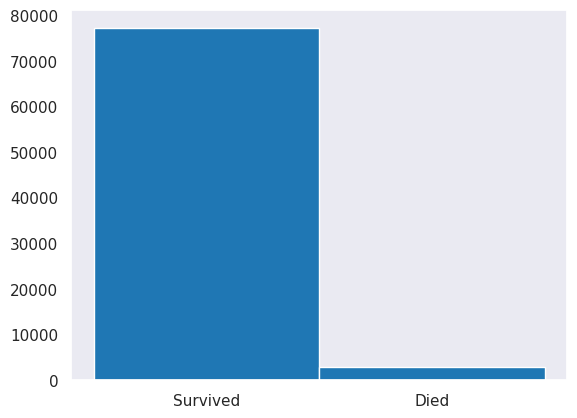

In [10]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

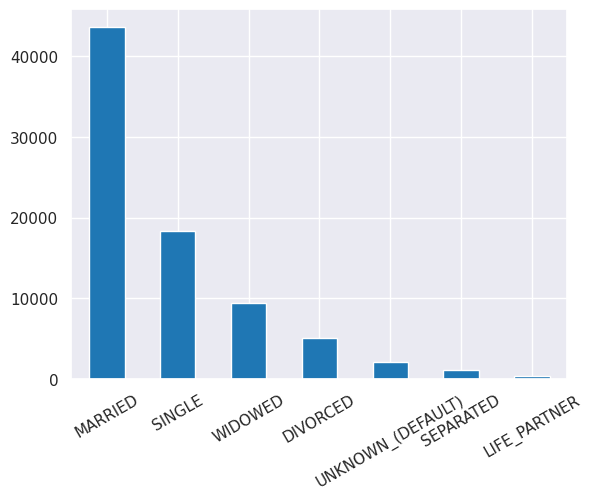

In [11]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>

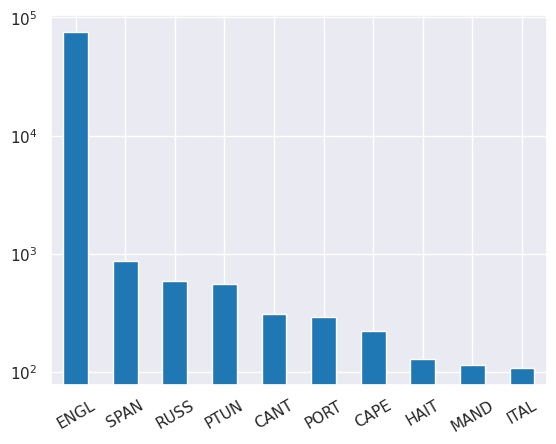

In [12]:
# TODO: Bar plot of another variable
x_lang_cnts = x_df["LANGUAGE"].value_counts().head(10)
x_lang_cnts.plot.bar(rot=30)
plt.yscale("log")
plt.show()

#### Corrélations

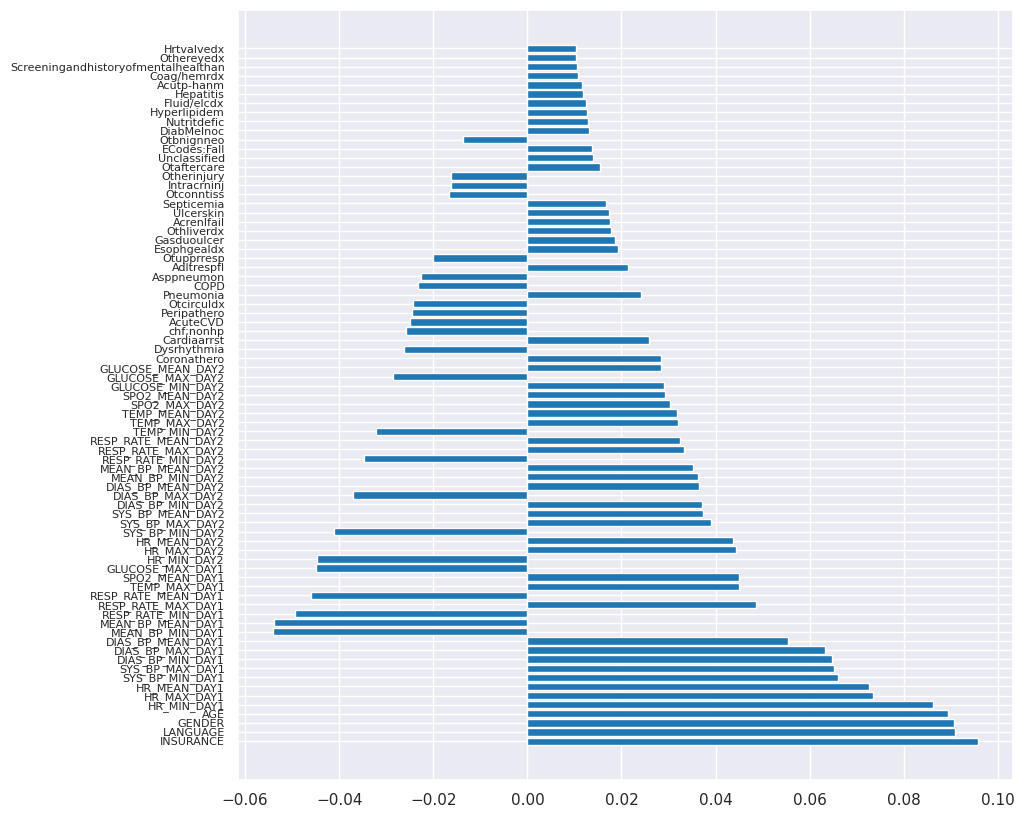

In [13]:
corr = []

for i in range(0,len(x_df.columns)):
    column = x_df.columns[i]
    corrCol = 0
    if(isinstance(x_df[column][0], str)): # so that the columns with strings could be taken into account
        col = x_df.iloc[:,i]
        label, level = pd.factorize(col)
        x_df['label'] = label
        corrCol = 0 if (np.abs(np.mean(np.array(x_df['label']))) < 10e-20) and (np.abs(np.std(np.array(x_df['label']))) < 10e-20) else (np.corrcoef(np.array(ys),np.array(x_df['label']))[0,1])
    else:
        corrCol = 0 if (np.abs(np.mean(np.array(x_df[column]))) < 10e-20) and (np.abs(np.std(np.array(x_df[column]))) < 10e-20) else (np.corrcoef(np.array(ys),np.array(x_df[column]))[0,1])
            
    corr.append(corrCol)


index_most=np.where(np.abs(corr)>0.01)
corr_most = [corr[i] for i in index_most[0]]
sorted_most_corr = sorted(corr_most,key=abs, reverse=True)
plt.figure(figsize=(10,10))
plt.barh(x_df.columns[index_most], sorted_most_corr, align='center')
plt.yticks(fontsize=8)
plt.show()

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

On remarque que d'une part les variables d'environnement sociétales telles que l'age, la langue, le genre ou le type d'insurance ont l'influence la plus forte sur la survie. D'autre part, on remarque que les constantes d'un patient au premier jour sont de bien meilleurs indicateurs de la survie que les constantes au deuxième.

#### Autres graphiques ou résultats d'une analyse exploratoire

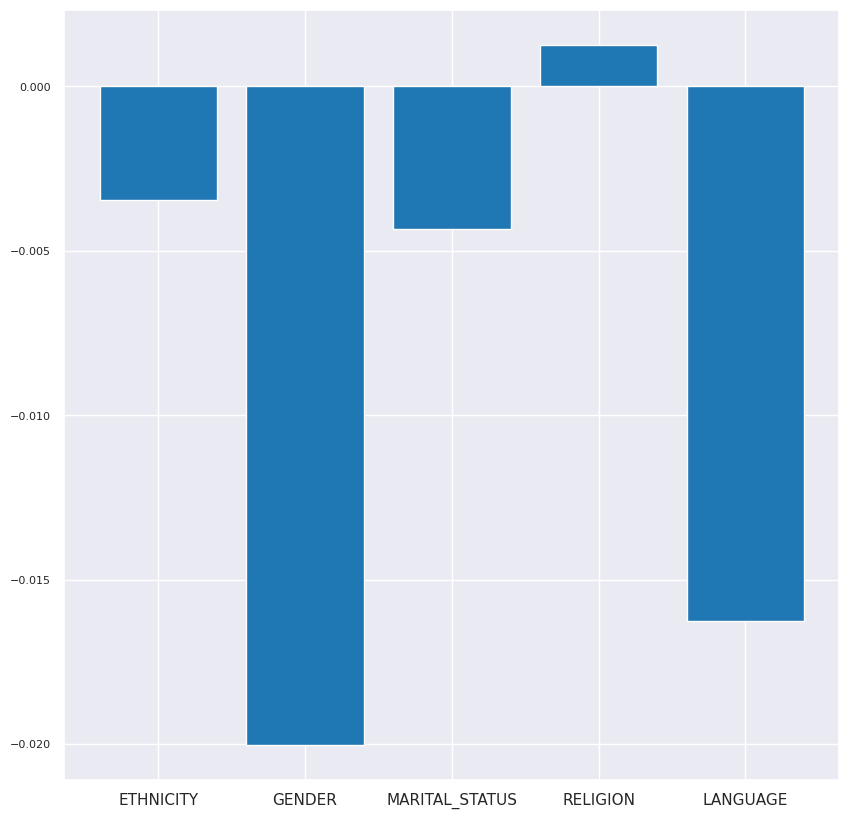

In [14]:
# TODO: Add graph
index_soc = np.array([np.where(x_df.columns == 'ETHNICITY'), np.where(x_df.columns == 'GENDER'),np.where(x_df.columns == 'MARITAL_STATUS'),np.where(x_df.columns == 'RELIGION'),np.where(x_df.columns == 'LANGUAGE')]).flatten()
corr_soc = [corr[i] for i in index_soc]
plt.figure(figsize=(10,10))
plt.bar(x_df.columns[index_soc], corr_soc)
plt.yticks(fontsize=8)
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

On a plot les variables de type sociétales et on remarque que le statut marital, l'éthnie et la religion n'ont qu'une influence marginale contrairement à la langue ou le genre.

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [15]:
print(x_df.shape, x_test_df.shape)

(79999, 338) (20001, 337)


In [16]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [17]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [18]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [19]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [20]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [21]:
print(x_df.shape, x_test_df.shape)

(79999, 338) (20001, 337)


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

In [22]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        #print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


print("Before :\n",x_test_df["RELIGION"].value_counts(), end="\n\n")
merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print("After : \n",x_test_df["RELIGION"].value_counts())

Before :
 CATHOLIC                  7517
NOT_SPECIFIED             3764
UNOBTAINABLE              2208
PROTESTANT_QUAKER         2208
JEWISH                    1855
OTHER                     1171
EPISCOPALIAN               338
CHRISTIAN_SCIENTIST        221
GREEK_ORTHODOX             216
BUDDHIST                   140
MUSLIM                      87
UNITARIAN-UNIVERSALIST      62
JEHOVAH'S_WITNESS           60
HINDU                       59
ROMANIAN_EAST._ORTH         42
7TH_DAY_ADVENTIST           32
BAPTIST                     16
HEBREW                       4
LUTHERAN                     1
Name: RELIGION, dtype: int64

After : 
 CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [23]:
# TODO: Other application of merge_rare_categories
# On ne regardera que les catégories non binaires, non numériques, ou aparentées pour des raisons évidentes
# Pour cela on va enlever les colonnes ayant moins de 2 valeurs uniques, ou plus de 1000
#Enfin, on regarde au cas par cas ce qui semble pertinent de regrouper (ex : l'assurance et les religions ne le sont pas)

print("Before : \n")
x_nb_diff_values = x_df.nunique()
x_nb_diff_values = x_nb_diff_values[x_nb_diff_values > 2]
x_nb_diff_values = x_nb_diff_values[x_nb_diff_values < 1000]
print(x_nb_diff_values)

#x_df["ETHNICITY"].value_counts()[2:].plot.bar() #on remarque que la majorité des valeurs sont concentrées sur une 20aine de catégories max (décroissance exponentielle), on va donc regrouper
merge_rare_categories([x_df, x_test_df], col="ETHNICITY", keep_n=20)


#x_df["LANGUAGE"].value_counts()[:].plot.bar()
merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=17)

#x_df["MARITAL_STATUS"].value_counts()[:].plot.bar() # lui est assez "binaire" donc on va le laisser tel quel
#x_df["INSURANCE"].value_counts()[:].plot.bar() # de même
#x_df["AGE"].value_counts()[:].plot.bar() # cette catégorie est numérique, on va la laisser telle quelle
#x_df["ICU"].value_counts()[:].plot.bar() # celle-ci est assez équitable, on va la laisser telle quelle
#x_df["label"].value_counts()[:].plot.bar() # cette catégorie est numérique mais une catégorie est non représentée, on va la supprimer
merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=5)


x_nb_diff_values = x_df.nunique()
x_nb_diff_values = x_nb_diff_values[x_nb_diff_values > 2]
x_nb_diff_values = x_nb_diff_values[x_nb_diff_values < 1000]
print("\n\n After : \n")
print(x_nb_diff_values)

Before : 

INSURANCE          5
LANGUAGE          68
RELIGION           6
MARITAL_STATUS     7
ETHNICITY         41
AGE               74
ICU                5
label              6
dtype: int64


 After : 

INSURANCE          5
LANGUAGE           5
RELIGION           6
MARITAL_STATUS     7
ETHNICITY         20
AGE               74
ICU                5
label              6
dtype: int64


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [24]:
def label_encode(df, other_df, only_binary=False):
    """
    Select categorical variables and encode them in integers.
    """
    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [25]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn,label
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,1,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,2


In [26]:
print(x_df.shape, ys.shape)

(79999, 338) (79999,)


In [27]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [28]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn,label
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,1,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,2


In [29]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,3,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [30]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1h_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1h_df = x_all_1h_df.iloc[: len(x_df)].copy()
x_test_1h_df = x_all_1h_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 338) (20001, 337)
(79999, 380) (20001, 380)


#### Suppression des variables à valeur unique (constantes)

In [31]:
const_cols = {col for col in x_1h_df if len(x_1h_df[col].unique()) == 1}
len(const_cols)

173

In [32]:
x_1h_df.drop(const_cols, axis="columns", inplace=True)
x_test_1h_df.drop(const_cols, axis="columns", inplace=True)

print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 207) (20001, 207)


### Création de l'ensemble de validation

In [33]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1h_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1h_df

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [34]:
# TODO: PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

pca = PCA(n_components=2)
pca.fit(x_train_scaled)
x_train_pca = pca.transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)

print(x_train_pca.shape, x_valid_pca.shape)
print(y_train.shape, y_valid.shape)

(55999, 2) (24000, 2)
(55999,) (24000,)


Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

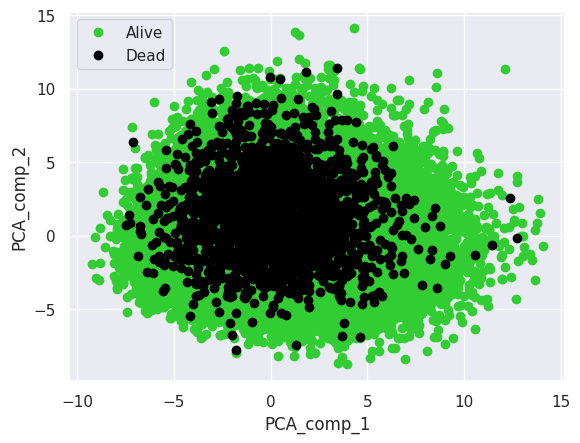

In [35]:
# TODO: Plot

df = pd.DataFrame(data = x_train_pca, columns = ['PCA_comp_1', 'PCA_comp_2'])
alive_x = [df.iloc[i,0] for i in range(0,len(df.iloc[:,0])) if y_train.iloc[i]==0]
alive_y = [df.iloc[i,1] for i in range(0,len(df.iloc[:,0])) if y_train.iloc[i]==0]
dead_x = [df.iloc[i,0] for i in range(0,len(df.iloc[:,0])) if y_train.iloc[i]!=0]
dead_y = [df.iloc[i,1] for i in range(0,len(df.iloc[:,0])) if y_train.iloc[i]!=0]

plt.plot(alive_x,alive_y, 'o', color="limegreen",label="Alive")
plt.plot(dead_x,dead_y,'o', color="black",label="Dead")
plt.xlabel("PCA_comp_1")
plt.ylabel("PCA_comp_2")
plt.legend()
    

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Le plot permet de comprendre ce que donne la PCA mais pas comment elle dessine ses decision boundaries.

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [36]:
SCORINGS = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [47]:
# TODO: Try other models

from sklearn import neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

model = ensemble.RandomForestClassifier(n_estimators=10)
#model = linear_model.LogisticRegression()
#model = neighbors.KNeighborsClassifier(n_neighbors=5)
#model = svm.SVC()
#model = naive_bayes.GaussianNB()
#model = DecisionTreeClassifier()

model.fit(x_train, y_train)  # training

RandomForestClassifier(n_estimators=10)

## 6. Évaluations

In [43]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")
# score of random forest: 0.5
# score of logistic regression: 0.506
# score of KNN: 0.501
# score of SVM: 0.5 (took 3.5min to fit the model)
# score of Naive Bayes: 0.505
# score of Decision Tree: 0.526

Balanced accuracy score: 0.501


### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [44]:
CV = 10

<span style="color:red">
    Répondre ci-dessous
</span>

In [46]:
# TODO: Cross-Validation
pcaCV = decomposition.PCA(n_components=CV)
modelCV = linear_model.LogisticRegression()
pipe = pipeline.Pipeline(steps=[("pca", pcaCV), ("logistic", modelCV)])

scores = model_selection.cross_val_score(pipe, x_train, y_train, cv=CV, scoring=SCORINGS)
print(f"\n{SCORINGS}: {scores.mean():.3g} +/- {scores.std():.3g}")


balanced_accuracy: 0.5 +/- 2.77e-05


* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

<!-- ![](img/boxplot-cv.png) >

<span style="color:red">
    Répondre ci-dessous
</span>

In [48]:
new_model = naive_bayes.GaussianNB()
pipe = pipeline.Pipeline(steps=[("pca", pcaCV), ("model", new_model)])
scores = model_selection.cross_val_score(pipe, x_train, y_train, cv=CV, scoring=SCORINGS)
print(f"\n{SCORINGS}: {scores.mean():.3g} +/- {scores.std():.3g}")


balanced_accuracy: 0.503 +/- 0.00299


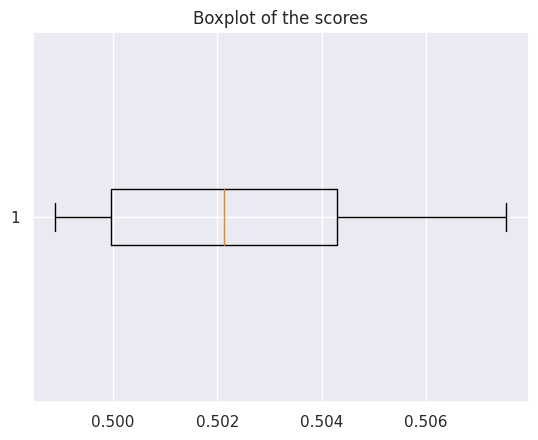

In [50]:
# Boxplot
plt.boxplot(scores, vert=False)
plt.title("Boxplot of the scores")
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

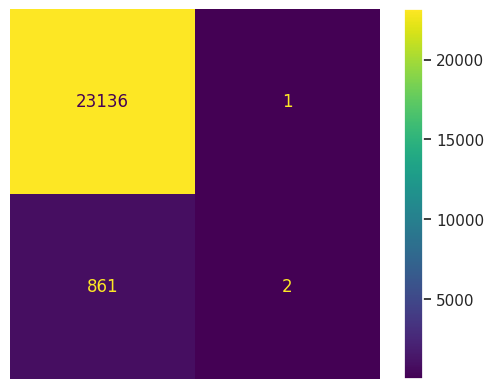

In [70]:
# TODO: Confusion Mtx
plt.axis(False)
metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, ax=plt.gca())

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

On a majoritairement des vrai positifs et des faux négatifs (erreur de type II). On a donc une bonne sensibilité mais une mauvaise spécificité.

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

In [59]:
# TODO: ROC
sklearn.metrics.roc_auc_score(y_valid, y_pred)

0.501137138143992

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Le ROC s'accorde avec les prédictions.

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [71]:
# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

scores = model_selection.cross_val_score(pipe, x_train, y_train, cv=CV, scoring=SCORINGS)
print(f"\n{SCORINGS}: {scores.mean():.3g} +/- {scores.std():.3g}")


balanced_accuracy: 0.529 +/- 0.00891


### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1h_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [48]:
predictions = model.predict(x_test_1h_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1h_df, x_test_1h_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2023-04-04T22-34-19.zip


---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---